# Import necessary packages

In [11]:
using DifferentialEquations, Graphs
using YardSale
using Plots

# Description of the model

Here we're going to use the functionalities of the ODE solver implemented in `YardSale.jl`.
These are simple functions that wrap the `DifferentialEquations.jl` package to solve the
ODE systems we're interested in. By wrapping, we are allowed to explore efficiently the
parameters space. 

The models we're going to explore belong to a wider class of models called _Asset Exchange Models_. These are 
models inspired in the statistical physics of interacting particles. The main idea is that
agents exchange assets in a network, just like particles exchange energy in a physical system.
The dynamics of the system is given by the exchange rules, which usually involve binary
transactions. For a review of these models, see for example _Greenberg, M., Gao, H.O. Twenty-five years of random asset exchange modeling. Eur. Phys. J. B 97, 69 (2024) [DOI](https://doi.org/10.1140/epjb/s10051-024-00695-3)._

Here, we're studying specifically and ODE approximation of one of these models, called the _"Extended Yard-Sale Model"_ (EYSM),
published in _Boghosian et al. (2017). Physica A, 476, 15-42 [DOI](https://doi.org/10.1016/j.physa.2017.01.071)._ 
For details on the derivation of the equations please refer to our original paper.

Given a network $a$, the model is defined by the following set of ODEs:
$$
\begin{equation*}
\dot{x}_i = \frac{T}{N} \bigg(-\beta_i x_i+\frac{1}{N}\sum_j \beta_j x_j\bigg) + \sum_j\kappa_{ij}(x_i-x_j)\min(x_i,x_j)
\tag{1} 
\end{equation*}

$$

where $x_i$ represents the (expected) relative wealth of agent $i$, and $T$ represents the temperature.
The parameters $\beta_i$ and $\kappa_{ij}$ are parameters which contain information about the network structure of $a$,
and the way in which agents get taxed and interact with each other, respectively.

As described in the original paper, the EYSM exhibits a second-order phase transition as a function of the temperature $T$ when the network is a complete graph. This transition is characterized by the emergence of an oligarchy at low temperatures, where a few agents accumulate most of the wealth. At high temperatures, the wealth is more evenly distributed among the agents. The transition is characterized by the order parameter $x_1$ (the wealth of the richest agent) as a function of the temperature $T$. In the thermodynamic limit, the order parameter behaves as 
$$
\begin{equation*}
x_1(T) = \begin{cases}
1 - T & \text{if } T \leq 1 \\ 
0 & \text{if } T > 1
\end{cases}
\tag{2}
\end{equation*}
$$

In this notebook, we're going to reproduce the phase transition of the EYSM in a complete graph, using the implementation of the ODE solver in `YardSale.jl`.

# 1. A first look at the model

Let's study the time evolution of the wealth distribution in the original EYSM. We'll set 
a system of few agents, and we'll plot the wealth of all agents as a function of time.

In [49]:
# Number of nodes
N = 16
# A complete graph with N nodes (Graphs.jl)
g = complete_graph(N)
# Interaction and taxation modes
interaction_mode = "A"
taxation_mode = "A"
# Temperature
T = 1.0
# Time span
tspan = (0.0, 30000)
dt = 10
# Seed
seed = 42
# Initial conditions
initial_conditions = "noisy" # Defaul, but you can also use "random", "custom", or "uniform"
;

In [50]:
# Solve the system
sol = solve_ode_net(
    g,
    tspan,
    interaction_mode,
    taxation_mode,
    T,
    seed;
    integrator = Tsit5(),
    initial_conditions = initial_conditions,
    saveat = dt
)
;

In [60]:
# Get the time series of the state variables, sorted by final state
x_t = hcat(sol.u...)[sortperm(sol.u[end]), :]

16×3001 Matrix{Float64}:
 0.0611785  0.0611742  0.0611699  …  0.0585937  0.0585937  0.0585937
 0.0615817  0.0615783  0.0615749     0.0585937  0.0585937  0.0585937
 0.0619628  0.0619606  0.0619584     0.0585937  0.0585937  0.0585937
 0.0619842  0.0619821  0.06198       0.0585937  0.0585937  0.0585937
 0.0622529  0.0622518  0.0622508     0.0585937  0.0585937  0.0585937
 0.0622729  0.062272   0.0622711  …  0.0585937  0.0585937  0.0585937
 0.0623031  0.0623023  0.0623015     0.0585937  0.0585937  0.0585937
 0.0623055  0.0623047  0.0623039     0.0585937  0.0585937  0.0585937
 0.0625274  0.0625276  0.0625278     0.0585938  0.0585938  0.0585938
 0.0626573  0.0626582  0.062659      0.0585938  0.0585938  0.0585938
 0.0627712  0.0627726  0.062774   …  0.0585939  0.0585939  0.0585939
 0.062798   0.0627995  0.062801      0.0585939  0.0585939  0.0585939
 0.0628232  0.0628249  0.0628265     0.058594   0.058594   0.058594
 0.0630102  0.0630128  0.0630154     0.0585949  0.0585949  0.0585949
 0.0630252

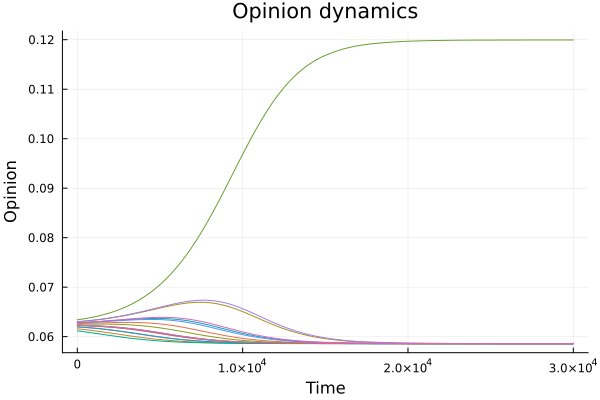

In [ ]:
# Make the paper plot
p = plot(

)